# Compute 4He form factors from 1-body densities

## Init

In [1]:
from typing import Optional
import os
import re
import pandas as pd
import numpy as np
import sympy
from scipy.interpolate import interp1d

import matplotlib.pylab as plt
import seaborn as sns

import gvar as gv
import lsqfit

## Utility Functions

In [2]:
def parse_label(fit, subs=True):
    """Parses the fit function and posteriror to latex label.
    
    If subs = False, don't substitude in posterior parameters.
    """
    expressions = {}
    values = {}
    for key, val in fit.p.items():
        if hasattr(val, "__iter__"):
            expr = sympy.symbols(" ".join([f"{key}{n}" for n, el in enumerate(val)]))
        else:
            expr = sympy.Symbol(key)

        expressions[key] = expr

        if hasattr(expr, "__iter__"):
            for ee, vv in zip(expr, val):
                values[sympy.latex(ee)] = vv
        else:
            values[sympy.latex(expr)] = val

    f_expr = fit.fcn(
        x=sympy.Symbol("x"), p={key: expr for key, expr in expressions.items()}
    )

    s = sympy.latex(f_expr)
    if subs:
        for pat, sub in values.items():
            s = s.replace(pat, str(sub))
            s = re.sub(r"e\+?([\-]?)[0]*([0-9]+)", " 10^{\g<1>\g<2>}", s)
    return re.sub(r"\+\s+\-", "-", s)

In [3]:
COLORS = sns.color_palette("hls", 2)


def plot_fit(fit: lsqfit.nonlinear_fit, ax: Optional[plt.Axes] = None) -> plt.Axes:
    """Plots a nonlinear_fit (data and fit result)."""
    _, ax = plt.subplots(figsize=(3, 2), dpi=300) if not ax else (None, ax)

    y_mean, y_sdev = gv.mean(fit.data[1]), gv.sdev(fit.data[1])
    ax.errorbar(
        fit.data[0],
        y_mean,
        y_sdev,
        marker="o",
        ms=2,
        ls="None",
        capsize=2,
        elinewidth=1,
        label="data",
        color=COLORS[0],
    )

    x_int = np.linspace(fit.data[0].min(), fit.data[0].max())
    y_fit = fit.fcn(x_int, fit.p)
    y_mean, y_sdev = gv.mean(y_fit), gv.sdev(y_fit)

    try:
        label = parse_label(fit)
        label = f"$f(x) = {label}$"
    except Exception as e:
        print(e)
        label = str(fit.p)

    ax.fill_between(
        x_int, y_mean - y_sdev, y_mean + y_sdev, color=COLORS[1], alpha=0.5, label="fit"
    )

    ax.legend(
        fancybox=False, frameon=False, bbox_to_anchor=(1.1, 0.5), loc="center left"
    )
    ax.set_title(label, size=8)

    return ax

## Definitions (needs user input)

In [4]:
HBARC = 197.3269804
MN = 938.918

For this code to run, you have to specify two directories:
    
1. `DATA_4HE_AV18`  which contains the `compton-dens-4he-av18-...-rho1b.dat`  files
2. `DATA_FF` which contains the single proton & neutron form factor data as specified in [[1707.09063]](https://arxiv.org/abs/1707.09063 )

In [5]:
DATA = "/home/ckoerber/data"
DATA_4HE_AV18 = "/home/ckoerber/data/nuc/4he/av18"

files = [f for f in os.listdir(DATA_4HE_AV18) if f.endswith(".dat")]
print("First rho1b file", files[0])

DATA_FF = "/home/ckoerber/data/nuc/NucleonFFData"
print("\nFF data:", os.listdir(DATA_FF))

First rho1b file compton-dens-4he-av18-empot-no3nf-om=6.00E+01-th=1.80E+02-nx=16-nphi=16-np12=np34=28+8-np3=36+8-nq4=nq=36+6-j12max=5-lmax=6-lsummax=14-tau4max=0-rho1b.dat

FF data: ['proton_baseline_sep272019_RE8414.dat', 'Ye2017gyb_neutron_lookup.dat']


## Parse file names to variables

In [6]:
patterns = (
    r"compton-dens-(?P<nuc>[0-9A-z]+)",
    r"\-(?P<potential>[a-z0-9]+)",
    r"(?:\-(?P<empot>(?:empot)))?",
    r"(?:\-(?P<tnf>(?:[a-z0-9]+)))?",
    r"(?:\-Lamnum=(?P<lambda>(?:[0-9\.e\+]+)))?",
    r"(?:\-tnfcut=(?P<tnfcut>(?:[0-9]+)))?",
    r"\-om=(?P<omega>(?:[0-9\.]+E[\+\-][0-9]+))",
    r"\-th=(?P<theta>(?:[0-9\.E\+]+))",
    r"\-nx=(?P<nx>(?:[0-9]+))",
    r"\-nphi=(?P<nphi>(?:[0-9]+))",
    r"\-np12\=np34\=(?P<np12_np34>(?:[0-9\+]+))",
    r"\-np3\=(?P<np3>(?:[0-9\+]+))",
    r"\-nq4\=nq=(?P<nq4_nq>(?:[0-9\+]+))",
    r"\-j12max=(?P<j12max>(?:[0-9]+))",
    r"\-lmax=(?P<lmax>(?:[0-9]+))",
    r"\-lsummax=(?P<lsummax>(?:[0-9]+))",
    r"\-tau4max=(?P<tau4max>(?:[0-9]+))",
    r"\-rho1b\.dat",
)
pattern = re.compile("".join(patterns))
pattern.search(files[0]).groupdict()

{'nuc': '4he',
 'potential': 'av18',
 'empot': 'empot',
 'tnf': 'no3nf',
 'lambda': None,
 'tnfcut': None,
 'omega': '6.00E+01',
 'theta': '1.80E+02',
 'nx': '16',
 'nphi': '16',
 'np12_np34': '28+8',
 'np3': '36+8',
 'nq4_nq': '36+6',
 'j12max': '5',
 'lmax': '6',
 'lsummax': '14',
 'tau4max': '0'}

In [7]:
dtypes = {
    int: ["nx", "nphi", "j12max", "lmax", "lsummax", "tau4max"],
    float: ["lambda", "omega", "theta"],
}

In [8]:
data = [pattern.search(f).groupdict() for f in files]
df = pd.DataFrame(data)
for dtype, cols in dtypes.items():
    for col in cols:
        df[col] = df[col].astype(dtype)

df["file"] = files
df.head()

,nuc,potential,empot,tnf,lambda,tnfcut,omega,theta,nx,nphi,np12_np34,np3,nq4_nq,j12max,lmax,lsummax,tau4max,file
0,4he,av18,empot,no3nf,NaN,None,60.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=6.00E+01-...
1,4he,av18,empot,urbix,100000000.0,3,0.0,180.0,8,12,28+8,36+8,36+6,4,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
2,4he,av18,empot,no3nf,NaN,None,98.7,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=9.87E+01-...
3,4he,av18,empot,urbix,100000000.0,3,0.0,180.0,8,4,28+8,36+8,36+6,4,6,14,0,compton-dens-4he-av18-empot-urbix-Lamnum=1.000...
4,4he,av18,empot,no3nf,NaN,None,80.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,compton-dens-4he-av18-empot-no3nf-om=8.00E+01-...


Only varying quantities are omega and theta

## File parsing

The routines below parse the `rho1b` files.

Results are dictionaries with keys specifying the matrix elements and channels

In [9]:
pp = r"MAXRHO1BINDEX\s+\=\s+(?P<max_rho_index>[0-9]+)"
pp += r".*"
pp += r"RHO1BINDX\s+\=(?P<rho_index>[0-9\*\,\-\s]+)"
pp += r".*"
pp += r"\/\s+(?P<om_theta>[0-9\.\-\+E ]+\n)"
pp += r"\s+(?P<rho>[0-9\.\-\+E\s]+\n)"


def parse_fortran_funny(string):
    """Converts fortran format arrys in file to python objects"""
    for pat, subs in {
        f"{key}*{val}": ", ".join([val] * int(key))
        for key, val in set(
            re.findall(r"([0-9]+)\*([\-0-9]+)", re.sub(r"\s+", " ", string))
        )
    }.items():
        string = string.replace(pat, subs)

    arr = np.array(list(map(int, string.split(","))))
    nd = len(arr) // 8
    return pd.DataFrame(
        data=arr.reshape([nd, 8]),
        columns=[
            "ms3_x2",
            "mt3_x2",
            "mjtot_x2",
            "ms3p_x2",
            "mt3p_x2",
            "mjtotp_x2",
            "k",
            "bk",
        ],
    )


parse = {
    "max_rho_index": int,
    "om_theta": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho": lambda el: np.array([float(ee) for ee in el.split(" ") if ee]),
    "rho_index": parse_fortran_funny,
}


def parse_1bd(address):
    """Reads in one-body density files"""
    with open(address, "r") as inp:
        t = inp.read()
    dd = re.search(pp, t, re.MULTILINE | re.DOTALL).groupdict()
    for key, val in parse.items():
        dd[key] = val(dd[key])
        
    channels = dd["rho_index"]
    channels["rho"] = dd["rho"]
    dd["channels"] = channels
    return dd

In [10]:
f = df.query("omega == 0").file.values[0]
dens = parse_1bd(os.path.join(DATA_4HE_AV18, f))

print("Dictionary keys are:", dens.keys())

Dictionary keys are: dict_keys(['max_rho_index', 'rho_index', 'om_theta', 'rho', 'channels'])


In [11]:
dens["channels"].sort_values("rho", ascending=False).head(10)

,ms3_x2,mt3_x2,mjtot_x2,ms3p_x2,mt3p_x2,mjtotp_x2,k,bk,rho
0,-1,-1,0,-1,-1,0,0,0,2.486910e-01
3,1,-1,0,1,-1,0,0,0,2.486910e-01
4,-1,1,0,-1,1,0,0,0,2.486910e-01
7,1,1,0,1,1,0,0,0,2.486910e-01
15,1,1,0,1,1,0,-1,1,1.015481e-11
11,1,-1,0,1,-1,0,-1,1,1.015481e-11
12,-1,1,0,-1,1,0,-1,1,7.130791e-12
8,-1,-1,0,-1,-1,0,-1,1,7.130791e-12
9,1,-1,0,-1,-1,0,-1,1,1.557841e-13
13,1,1,0,-1,1,0,-1,1,1.557841e-13


The entries `k` and `bk` encode angular dependence of the one-body operator
$$
O_{1} ( \vec k_{1} \  \mu' \mu \   \nu  \  \vec k ' \vec k ) \equiv \sum_{K=0}^{1}\sum_{\kappa=-K}^{K} \sqrt{\frac{4\pi}{2K+1}} \, k_{1}^{K} \, Y_{K\kappa}(\hat k_{1})
\tilde O_{1} ( K \kappa \  \mu' \mu \   \nu  \  \vec k ' \vec k )
$$
This would suggest, for the identity operation, $k = b_k = 0$.

*Question:*
Is this the same $k_1$ which appears in the SO force? If so, I don't have to evaluate 2b ops to get the SO done.

In [12]:
IDX_QUERY = (
    "k == bk == 0"
    " and mt3_x2 == mt3p_x2"
    " and mjtot_x2 == mjtotp_x2"
    " and ms3_x2 == ms3p_x2"
)

norm = dens["channels"].query(IDX_QUERY)["rho"].sum()
print("norm (k==0==bk):", norm)
print("other contributions:", dens["channels"]["rho"].sum() - norm)

norm (k==0==bk): 0.9947641492
other contributions: -3.129739800655784e-10


## File functions

In [13]:
def compute_norm(data, ms3_x2=None):
    """Computes the norm of 1-body density given density data"""
    qquery = IDX_QUERY + " and ms3_x2 == @ms3_x2" if ms3_x2 is not None else IDX_QUERY
    return data["channels"].query(qquery)["rho"].sum()


def compute_norm_from_file(ff, data=DATA_4HE_AV18, ms3_x2=None):
    """Computes the norm of 1-body density given density file"""
    dd = parse_1bd(os.path.join(data, ff))
    return compute_norm(dd, ms3_x2=ms3_x2)


print("norm:", compute_norm(dens))
print("norm-p:", compute_norm(dens, ms3_x2=1))
print("norm-n:", compute_norm(dens, ms3_x2=-1))

norm: 0.9947641492
norm-p: 0.4973820746
norm-n: 0.4973820746


## Read in GE data

In [14]:
def dipole_FF(q2):
    """Returns dipole form factor named GD in notes.
    
    Here, q2 is in GeV**2"""
    return 1 / (1 + q2 / (0.71)) ** 2

In [15]:
#Read in data
gp_data = (
    pd.read_csv(
        os.path.join(DATA_FF, "proton_baseline_sep272019_RE8414.dat"), sep="\s+",
    )
    .set_index("Q2")
    .rename(columns={"GEp/GD": "gep", "GMp/muGD": "gmp"})[["gep", "gmp"]]
)

# Mutliply by GD
gp_data["gep"] *= dipole_FF(gp_data.index.values)
gp_data["gmp"] *= dipole_FF(gp_data.index.values)

# convert q2 to MeV**2
gp_data.index = gp_data.index * 1000 ** 2  

# Interpolate
gep = interp1d(gp_data.index, gp_data.gep.values, kind="cubic")
gmp = interp1d(gp_data.index, gp_data.gmp.values, kind="cubic")

In [16]:
#Read in data
gn_data = (
    pd.read_csv(os.path.join(DATA_FF, "Ye2017gyb_neutron_lookup.dat"), sep="\s+",)
    .set_index("Q2")
    .rename(columns={"GEn/GD": "gen", "GMn/muGD": "gmn"})[["gen", "gmn"]]
)

# Mutliply by GD
gn_data["gen"] *= dipole_FF(gp_data.index.values)
gn_data["gmn"] *= dipole_FF(gp_data.index.values)

# convert q2 to MeV**2
gn_data.index = gn_data.index * 1000 ** 2

# Interpolate
gen = interp1d(gn_data.index, gn_data.gen.values, kind="cubic")
gmn = interp1d(gn_data.index, gn_data.gmn.values, kind="cubic")

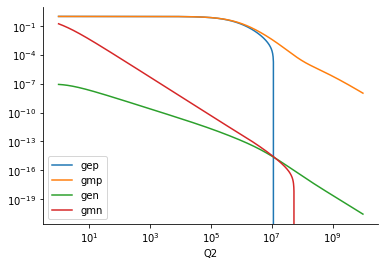

In [17]:
ax = gp_data.plot(y="gep")
gp_data.plot(y="gmp", ax=ax)
gn_data.plot(y="gen", ax=ax)
gn_data.plot(y="gmn", ax=ax)

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
sns.despine()
plt.show()

In [18]:
def ge_correction(k2, rho, mt3_x2):
    """Computes - k^2/8/MN * GE(k^2)
    
    k^2 is in MeV^2
    """
    gep_k2, gen_k2 = gep(k2), gen(k2)
    return (-k2 / 8 / MN ** 2 * np.where(mt3_x2 == 1, gep_k2, gen_k2) * rho).sum()


def compute_ge_correction_norm_from_file(ff, data=DATA_4HE_AV18):
    """Computes the GE correction given a density file
    """
    dd = parse_1bd(os.path.join(data, ff))
    tmp = dd["channels"].query(IDX_QUERY)
    rho = tmp["rho"].values
    mt3_x2 = tmp["mt3_x2"].values
    q2 = (dd["om_theta"][0] * HBARC) ** 2
    if q2 == 0:
        q2 = gp_data.index.min()  # Avoid FF interpolation range issues
    return ge_correction(q2, rho, mt3_x2)

## Run computations

In [19]:
df["norm"] = df.file.apply(compute_norm_from_file)
df["norm_p"] = df.file.apply(compute_norm_from_file, ms3_x2=1)
df["ge_correction"] = df.file.apply(compute_ge_correction_norm_from_file)
df.drop(columns=["lambda", "tnfcut", "file"]).sort_values("omega").head(10)

,nuc,potential,empot,tnf,omega,theta,nx,nphi,np12_np34,np3,nq4_nq,j12max,lmax,lsummax,tau4max,norm,norm_p,ge_correction
16,4he,av18,empot,urbix,0.0,180.0,8,16,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052507e-08
1,4he,av18,empot,urbix,0.0,180.0,8,12,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052507e-08
14,4he,av18,empot,urbix,0.0,180.0,12,4,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052506e-08
3,4he,av18,empot,urbix,0.0,180.0,8,4,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052507e-08
12,4he,av18,empot,no3nf,0.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,0.996737,0.498369,-7.066497e-08
11,4he,av18,empot,urbix,0.0,180.0,8,8,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052507e-08
9,4he,av18,empot,urbix,0.0,180.0,16,4,28+8,36+8,36+6,4,6,14,0,0.994764,0.497382,-7.052507e-08
8,4he,av18,empot,no3nf,10.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,0.992843,0.496422,-7.036777e-06
13,4he,av18,empot,no3nf,20.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,0.981216,0.490608,-2.779220e-05
15,4he,av18,empot,no3nf,30.0,180.0,16,16,28+8,36+8,36+6,5,6,14,0,0.962204,0.481102,-6.122797e-05


## Prepare plots & fits

In [20]:
qquery = {
    "theta": 180,
    "nuc": "'4he'",
    "potential": "'av18'",
    "tnf": "'no3nf'",
    "j12max": 5,
    "empot": "'empot'",
}
ddf = df.query(" and ".join(f"{key} == {val}" for key, val in qquery.items()))[
    ["omega", "norm", "norm_p", "ge_correction"]
].sort_values("omega")
ddf["q"] = ddf["omega"] * 2
ddf = ddf.set_index("q")
print(ddf[["norm", "ge_correction"]])

           norm  ge_correction
q                             
0.0    0.996737  -7.066497e-08
20.0   0.992843  -7.036777e-06
40.0   0.981216  -2.779220e-05
60.0   0.962204  -6.122797e-05
80.0   0.936306  -1.056956e-04
98.6   0.906521  -1.552466e-04
120.0  0.866665  -2.187967e-04
140.0  0.824616  -2.822442e-04
160.0  0.778968  -3.466618e-04
180.0  0.730687  -4.094418e-04
197.4  0.687462  -4.606455e-04


### Run fits

Nucleus
{'theta': 180, 'nuc': "'4he'", 'potential': "'av18'", 'tnf': "'no3nf'", 'j12max': 5, 'empot': "'empot'"}

 fit function: c x^{2} + 1 

Least Square Fit:
  chi2/dof [dof] = 0.74 [9]    Q = 0.67    logGBF = 18.108

Parameters:
              c   -8.94(17)e-06      [ -1.0 (1.0) ]  

Fit:
     x[k]           y[k]        f(x[k],p)
-----------------------------------------
        0    0.9967 (65)            1 (0)  
       20    0.9928 (65)    0.996423 (70)  
       40    0.9812 (65)     0.98569 (28)  
       60    0.9622 (65)     0.96781 (63)  
       80    0.9363 (65)      0.9428 (11)  
     98.6    0.9065 (65)      0.9131 (17)  *
      120    0.8667 (65)      0.8712 (25)  
      140    0.8246 (65)      0.8247 (34)  
      160    0.7790 (65)      0.7711 (45)  *

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 3/0.0)
  fitter = scipy_least_squares    method = trf

r0 = sqrt(-6*c1) * hbarc : 1.445(14) fm


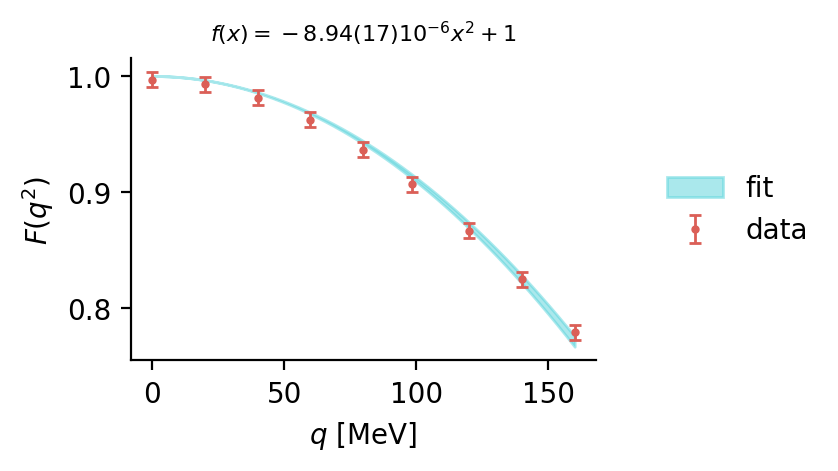

In [21]:
tmp = ddf.loc[:160]
x = tmp.index.values
y = gv.gvar(tmp.norm.values, [(1 - ddf.norm.loc[0]) * 2] * tmp.shape[0])


def poly_x2(x, p):
    """Computes $f(x) = 1 - \sum_{n=0} c_n x^{2n + 2}$.
    
    The prior p must contain the array c.
    """
    res = 1
    if hasattr(p["c"], "__iter__"):
        for n, cn in enumerate(p["c"]):
            res += x ** (2 * n + 2) * cn
    else:
        res += x ** (2) * p["c"]
    return res


# Prior fit parameter to be normally distributed at N(mu=-1, sigma=1)
prior = {"c": gv.gvar(-1, 1)}

# Compute posterior
fit = lsqfit.nonlinear_fit((x, y), fcn=poly_x2, prior=prior)

print("Nucleus")
print(qquery)
print("\n fit function:", parse_label(fit, subs=False), "\n")
print(fit.format(maxline=True))
print("r0 = sqrt(-6*c1) * hbarc :", gv.sqrt(-fit.p["c"] * 6) * HBARC, "fm")

# Plot
fig, ax = plt.subplots(dpi=200, figsize=(3, 2))
plot_fit(fit, ax=ax)
ax.set_ylabel("$F(q^2)$")
ax.set_xlabel("$q$ [MeV]")
sns.despine()
plt.show()